# PTEN in Endo and GBM

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
import gseapy as gp
import re
import sys 

import cptac
import cptac.utils as u

In [23]:
gbm = cptac.Gbm()
endo = cptac.Endometrial()

In [3]:
cancer1 = "GBM"
cancer2 = "Endometrial"
gene = 'PTEN'

In [4]:
#GBM ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot = gbm.get_proteomics()
prot_list = list(prot.columns)
prot_and_mutations = gbm.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status = mut_status.dropna(axis=1,how='all')

In [5]:
col_list = list(mut_status.columns)
col_list.remove('binary_mutations')

print("Doing t-test comparisons for GBM\n")

# Call wrap_ttest, pass in formatted dataframe
wrap_results = u.wrap_ttest(mut_status, 'binary_mutations', col_list, return_all=True)

Doing t-test comparisons for GBM



C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\fromnumeric.py:3367: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\brittany henderson\Anaconda3\envs\Research\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


No significant comparisons.


In [6]:
wrap_results.loc[wrap_results['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
0,PTEN_proteomics,0.000032


In [7]:
# endo ttest
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest
prot2 = endo.get_proteomics()
prot_list2 = list(prot2.columns)
prot_and_mutations = endo.join_omics_to_mutations(
    mutations_genes = [gene], omics_df_name = 'proteomics', omics_genes = prot_list2)  

# Step 2 - Create binary column 
prot_and_mutations['binary_mutations'] = np.where(
            prot_and_mutations[gene+'_Mutation_Status'] == 'Wildtype_Tumor', 'Wildtype', 'Mutated')

# Step 3 - Format the dataframe correctly for the T-test(just omics and binary columns for tumors)
tumors = prot_and_mutations[prot_and_mutations.Sample_Status == 'Tumor'] #drop Normal samples
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
mut_status = tumors.drop(columns_to_drop, axis = 1)
mut_status2 = mut_status.dropna(axis=1,how='all')

In [8]:
col_list2 = list(mut_status2.columns)
col_list2.remove('binary_mutations')

print("Doing t-test comparisons for Endometrial")

# Call wrap_ttest, pass in formatted dataframe
wrap_results2 = u.wrap_ttest(mut_status2, 'binary_mutations', col_list2, return_all=True)

Doing t-test comparisons for Endometrial
78 significant comparisons!


In [9]:
wrap_results2.loc[wrap_results2['Comparison'] == gene+"_proteomics"]

,Comparison,P_Value
7303,PTEN_proteomics,0.018255


In [10]:
#combine pval results
combined = wrap_results.merge(wrap_results2, on='Comparison')
combined = combined.replace(regex=True,to_replace='_proteomics', value='')

In [15]:
# Green = interacting protein
interacting_list = u.get_interacting_proteins(gene)
combined["color"] = np.where(combined["Comparison"].isin(interacting_list), "red", "black")
print(interacting_list)
#combined.loc[combined['color'] == 'red']

['MDM2', 'CSNK2A1', 'PDGFRB', 'PIK3R2', 'PIK3C3', 'CSNK2A2', 'SLC9A3R1', 'PIK3R3', 'USP13', 'PIK3CA', 'TP53', 'EGFR', 'PIK3CB', 'PTK2', 'USP7', 'XIAP', 'PTEN', 'PREX2', 'MAST2', 'PIK3CD', 'ROCK1', 'SHC1', 'NEDD4', 'INPP4B', 'PIK3R1', 'AKT1', 'MVP', 'MAGI3']


Visualize all P-values

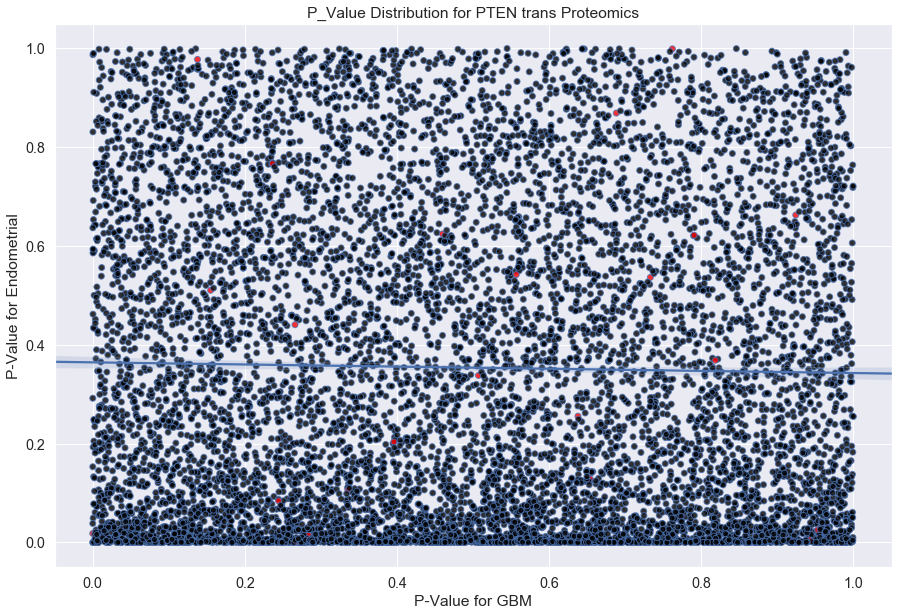

In [19]:
# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=combined, scatter_kws={'facecolors':combined['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

Zoom x-axis (low endometrial p-values)

In [73]:
low_endo_pvals = combined.loc[combined['P_Value_y'] <= 0.05] #graph

# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=low_endo_pvals, 
                   scatter_kws={'facecolors':low_endo_pvals['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics (zoomed x-axis)")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

Zoom y-axis (low gbm p-values)

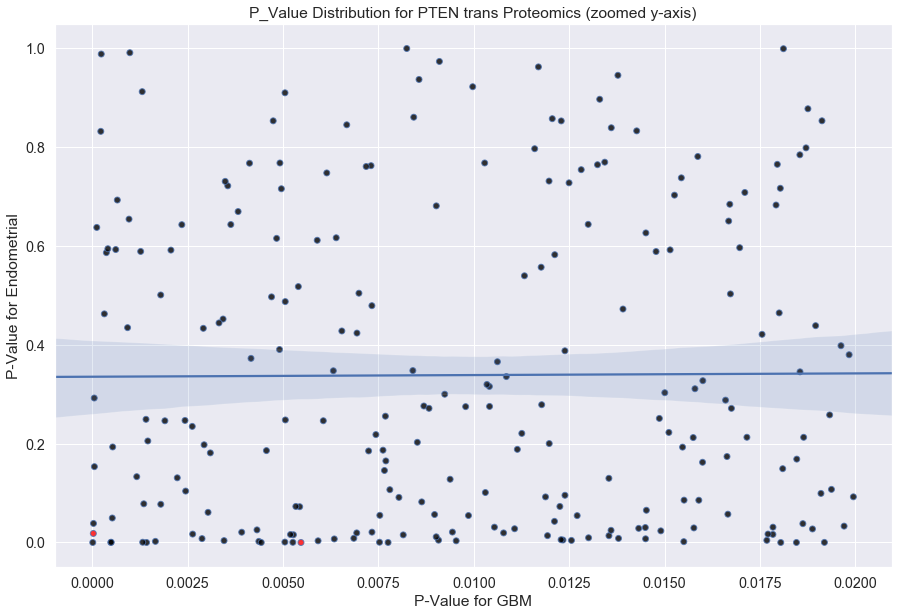

In [90]:
low_gbm_pvals = combined.loc[combined['P_Value_x'] <= 0.02] #FIX not working with graph above .02

# Format figure size and font
plt.rcParams['figure.figsize']=(15,10)
sns.set(font_scale = 1.3)

# Format title and axis
plot = sns.regplot(x="P_Value_x", y="P_Value_y", data=low_gbm_pvals, scatter_kws={'facecolors':low_gbm_pvals['color']})
plot.set_title("P_Value Distribution for "+gene+" trans Proteomics (zoomed y-axis)")
plot.set(xlabel = 'P-Value for '+cancer1)
plot.set(ylabel = 'P-Value for '+cancer2)

plt.show()
plt.clf()
plt.close()

# GSEA 

In [56]:
# corners for gsea test for zoomed x-axis (0-1 range gbm pvals)
low = combined.loc[combined['P_Value_y'] <= 0.05]
low_left_corner = low.loc[low['P_Value_x'] <= 0.05] 
low_right_corner = low.loc[low['P_Value_x'] >= 0.5] 

print("Number of both low:", len(low_left_corner))
print("Number of low endo, high gbm:", len(low_right_corner))

# corners for gsea test for zoomed y-axis (0-1 range endo pvals)
high = combined.loc[combined['P_Value_y'] >= 0.5] 
high_left_corner = high.loc[high['P_Value_x'] <= 0.05] 
high_right_corner = high.loc[high['P_Value_x'] >= 0.5]  
print("Number of high endo, low gbm:", len(high_left_corner))
print("Number of both high:", len(high_right_corner))

NameError: name 'combined' is not defined

In [103]:
# gsea for lower left corner (both low pvals)
both_low_pvals = list(low_left_corner['Comparison'])
print("Number of genes for both low pvals:", len(both_low_pvals))

both_low_gsea = gp.enrichr(
    gene_list = both_low_pvals, description='Tumor_partition', gene_sets='KEGG_2016')

Number of genes for both low pvals: 131


2019-12-14 17:05:40,851 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


In [104]:
both_low_gsea.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Phosphatidylinositol signaling system_Homo sap...,5/98,0.000466,0.136502,0,0,7.789375,59.756874,PPIP5K1;PIK3CA;PTEN;PIP5K1A;CDIPT,KEGG_2016
1,Central carbon metabolism in cancer_Homo sapie...,4/67,0.000979,0.143464,0,0,9.114732,63.153182,LDHA;PIK3CA;ERBB2;PTEN,KEGG_2016
2,Inositol phosphate metabolism_Homo sapiens_hsa...,4/71,0.001217,0.118826,0,0,8.601226,57.728495,PIK3CA;PTEN;PIP5K1A;CDIPT,KEGG_2016
3,Small cell lung cancer_Homo sapiens_hsa05222,4/86,0.002466,0.180632,0,0,7.101012,42.642779,PIK3CA;PTEN;FN1;BCL2L1,KEGG_2016
4,Glycosaminoglycan biosynthesis - keratan sulfa...,2/15,0.004228,0.247741,0,0,20.356234,111.269298,CHST6;B4GALT4,KEGG_2016


In [105]:
# gsea for low right corner (low endo, high gbm)
low_endo_high_gbm = list(low_right_corner['Comparison'])
print("Number of genes for low_endo_high_gbm:", len(low_endo_high_gbm))

low_endo_high_gbm_gsea = gp.enrichr(
    gene_list = low_endo_high_gbm, description='Tumor_partition', gene_sets='KEGG_2016')

Number of genes for low_endo_high_gbm: 130


2019-12-14 17:06:20,131 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


In [119]:
low_endo_high_gbm_gsea.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Spliceosome_Homo sapiens_hsa03040,6/134,0.000244,0.071600,0,0,6.888634,57.291585,LSM7;SF3B3;HNRNPU;WBP11;SNRNP200;CHERP,KEGG_2016
1,Endocytosis_Homo sapiens_hsa04144,7/259,0.001540,0.225669,0,0,4.158004,26.926028,VPS29;ACAP2;FOLR2;PRKCZ;VPS36;EGFR;HLA-E,KEGG_2016
2,Pyrimidine metabolism_Homo sapiens_hsa00240,4/105,0.004913,0.479792,0,0,5.860806,31.155825,ZNRD1;CANT1;ENTPD3;TYMP,KEGG_2016
3,Primary bile acid biosynthesis_Homo sapiens_hs...,2/17,0.005349,0.391810,0,0,18.099548,94.676116,HSD3B7;CYP7B1,KEGG_2016
4,Mismatch repair_Homo sapiens_hsa03430,2/23,0.009701,0.568466,0,0,13.377926,62.014037,LIG1;RFC2,KEGG_2016


Range 0-1 endo (upper corners)

In [107]:
# gsea for high left corner (high endo, low gbm)
high_endo_low_gbm = list(high_left_corner['Comparison'])
print("Number of genes for high_endo_low_gbm:", len(high_endo_low_gbm))

high_endo_low_gbm_gsea = gp.enrichr(
    gene_list = high_endo_low_gbm, description='Tumor_partition', gene_sets='KEGG_2016')

Number of genes for high_endo_low_gbm: 62


2019-12-14 17:06:39,184 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


In [108]:
high_endo_low_gbm_gsea.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Endocytosis_Homo sapiens_hsa04144,5/259,0.001242,0.364022,0,0,6.227426,41.665919,TGFB2;KIF5C;CAV1;CXCR4;IGF1R,KEGG_2016
1,Hypertrophic cardiomyopathy (HCM)_Homo sapiens...,3/83,0.002185,0.320090,0,0,11.659541,71.428431,TGFB2;TPM4;TPM2,KEGG_2016
2,MicroRNAs in cancer_Homo sapiens_hsa05206,5/297,0.002264,0.221079,0,0,5.430651,33.076994,TGFB2;IRS1;BCL2;SPRY2;FOXP1,KEGG_2016
3,Dilated cardiomyopathy_Homo sapiens_hsa05414,3/90,0.002751,0.201516,0,0,10.752688,63.395334,TGFB2;TPM4;TPM2,KEGG_2016
4,Focal adhesion_Homo sapiens_hsa04510,4/202,0.003567,0.209050,0,0,6.387736,36.000745,CAV1;BCL2;FLNC;IGF1R,KEGG_2016


In [109]:
# gsea for high right corner (high endo, high gbm)
both_high = list(high_right_corner['Comparison'])
print("Number of genes for both_high:", len(both_high))

both_high_gsea = gp.enrichr(
    gene_list = both_high, description='Tumor_partition', gene_sets='KEGG_2016')

Number of genes for both_high: 65


2019-12-14 17:06:49,288 Warning: No enrich terms using library KEGG_2016 when cutoff = 0.05


In [110]:
both_high_gsea.res2d.head()

,Term,Overlap,P-value,Adjusted P-value,Old P-value,Old Adjusted P-value,Odds Ratio,Combined Score,Genes,Gene_set
0,Ribosome_Homo sapiens_hsa03010,3/137,0.010080,1.0,0,0,6.737788,30.975169,MRPS15;MRPL9;MRPL23,KEGG_2016
1,RNA transport_Homo sapiens_hsa03013,3/172,0.018497,1.0,0,0,5.366726,21.413998,RAN;EIF3A;RGPD3,KEGG_2016
2,Complement and coagulation cascades_Homo sapie...,2/79,0.027293,1.0,0,0,7.789679,28.051614,PROC;SERPINC1,KEGG_2016
3,Oocyte meiosis_Homo sapiens_hsa04114,2/123,0.060722,1.0,0,0,5.003127,14.016032,ITPR3;ANAPC1,KEGG_2016
4,Glycosaminoglycan biosynthesis - chondroitin s...,1/20,0.063061,1.0,0,0,15.384615,42.517857,CHPF,KEGG_2016


# Check Directionality, Visualize t-tests

In [28]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
gene_list = ['ACAP2']
prot_and_mut = gbm.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = gene_list) 

# Step 2 - Create the binary column needed to do the comparison
prot_and_mut['PTEN_mutation_gbm'] = prot_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
mut_wt = prot_and_mut.loc[prot_and_mut['Sample_Status'] == 'Tumor']
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
gbm_binary_prot = mut_wt.drop(columns_to_drop, axis = 1)
gbm_binary_prot

Name,ACAP2_proteomics,PTEN_mutation_gbm
Sample_ID,,
S001,-0.217870,Mutated
S002,0.094480,Wildtype
S003,0.092034,Mutated
S004,-0.210237,Mutated
S005,-0.054126,Wildtype
...,...,...
S100,0.223449,Mutated
S101,-0.240919,Wildtype
S102,-0.172774,Wildtype


In [44]:
gbm_prot_list = list(gbm_binary_prot.columns).remove('PTEN_mutation_gbm')

# Step 4 - T-test 
print("Doing t-test comparison for", cancer1)
gbm_pval_results = u.wrap_ttest(gbm_binary_prot, 'PTEN_mutation_gbm', gbm_prot_list,verbose=True)
gbm_pval_results

Doing t-test comparison for GBM
ACAP2_proteomics :  0.9908670066216898
No significant comparisons.


In [49]:
# Step 1 - Create dataframe in order to do comparisons with wrap_ttest  
gene_list = ['ACAP2']
prot_and_mut = endo.join_omics_to_mutations(
    mutations_genes = gene, omics_df_name = 'proteomics', omics_genes = gene_list) 

# Step 2 - Create the binary column needed to do the comparison
prot_and_mut['PTEN_mutation_en'] = prot_and_mut[gene+'_Mutation_Status'].apply(
    lambda x: 'Wildtype' if x == 'Wildtype_Tumor' else 'Mutated')

# Step 3 - Format
mut_wt = prot_and_mut.loc[prot_and_mut['Sample_Status'] == 'Tumor']
columns_to_drop = [gene+"_Mutation", gene+"_Location", gene+"_Mutation_Status", "Sample_Status"]
en_binary_prot = mut_wt.drop(columns_to_drop, axis = 1)

In [46]:
en_prot_list = list(en_binary_prot.columns).remove('PTEN_mutation_en')

# Step 4 - T-test 
print("Doing t-test comparison for", cancer2)
en_pval_results = u.wrap_ttest(en_binary_prot, 'PTEN_mutation_en', en_prot_list,verbose=True)
en_pval_results

Doing t-test comparison for Endometrial
ACAP2_proteomics :  0.01345547276323311
1 significant comparisons!


,Comparison,P_Value
0,ACAP2_proteomics,0.013455


In [47]:
pan_cancer = gbm_binary_prot.join(en_binary_prot, 
                 lsuffix='_gbm', rsuffix='_en')
pan_cancer

Name,ACAP2_proteomics_gbm,PTEN_mutation_gbm,ACAP2_proteomics_en,PTEN_mutation_en
Sample_ID,,,,
S001,-0.217870,Mutated,-0.46000,Mutated
S002,0.094480,Wildtype,-0.19100,Mutated
S003,0.092034,Mutated,-0.04080,Mutated
S004,-0.210237,Mutated,NaN,NaN
S005,-0.054126,Wildtype,-0.46800,Mutated
...,...,...,...,...
S100,0.223449,Mutated,0.52900,Wildtype
S101,-0.240919,Wildtype,-0.00356,Wildtype
S102,-0.172774,Wildtype,-0.37800,Wildtype


In [ ]:
# note, weird plot when combined cancers (2 columns of PTEN mutation 
#status different, not a common way to do hue)
# also tried scatterplot to combine
# look at a different way

[Text(0, 0.5, 'ACAP2 Proteomics'), Text(0.5, 0, 'PTEN mutation status')]

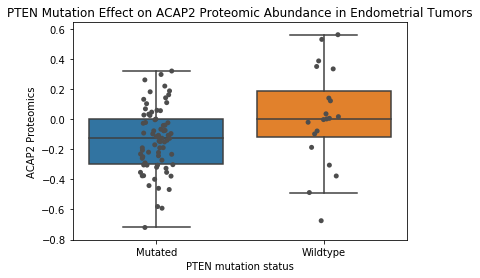

In [54]:
boxplot = sns.boxplot(x='PTEN_mutation_en', y="ACAP2_proteomics", 
                         data = en_binary_prot, showfliers = False)    
boxplot.set_title("PTEN Mutation Effect on ACAP2 Proteomic Abundance in Endometrial Tumors")
boxplot = sns.stripplot(x='PTEN_mutation_en', y="ACAP2_proteomics",  
                        data = en_binary_prot, jitter = True, color = ".3", dodge = True)
boxplot.set(xlabel = 'PTEN mutation status', ylabel = 'ACAP2 Proteomics')

[Text(0, 0.5, 'ACAP2 Proteomics'), Text(0.5, 0, 'PTEN mutation status')]

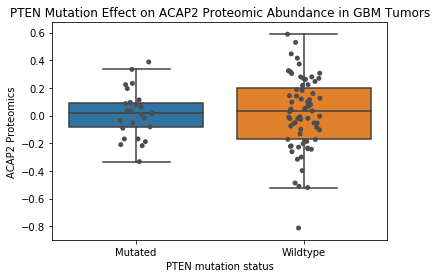

In [55]:
boxplot = sns.boxplot(x='PTEN_mutation_gbm', y="ACAP2_proteomics", 
                         data = gbm_binary_prot, showfliers = False)    
boxplot.set_title("PTEN Mutation Effect on ACAP2 Proteomic Abundance in GBM Tumors")
boxplot = sns.stripplot(x='PTEN_mutation_gbm', y="ACAP2_proteomics",  
                        data = gbm_binary_prot, jitter = True, color = ".3", dodge = True)
boxplot.set(xlabel = 'PTEN mutation status', ylabel = 'ACAP2 Proteomics')